# Attribution Demo 

<a target="_blank" href="https://colab.research.google.com/github/safety-research/circuit-tracer/blob/main/demos/attribute_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this demo, you'll learn how to load models and perform attribution on them.

In [1]:
import sys
from huggingface_hub import notebook_login
sys.path.append('../../circuit-tracer')
sys.path.append('../../circuit-tracer/demos')
IN_COLAB = False

/home/jiaweizhang/anaconda3/envs/circuit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if meet any error:
# !pip install transformer_lens
# !pip install transformers==4.47.0
# !pip install -U numpy

In [3]:
from pathlib import Path
import torch

from circuit_tracer import ReplacementModel, attribute
from circuit_tracer.utils import create_graph_files

First, load your model and transcoders by name. `model_name` is a normal HuggingFace / [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens) model name; we'll use `google/gemma-2-2b`. We set `transcoder_name` to `gemma`, which is shorthand for the [Gemma Scope](https://arxiv.org/abs/2408.05147) transcoders; we take the transcoders with lowest L0 (mean # of active features) for each layer.

We additionally support `model_name = "meta-llama/Llama-3.2-1B"`, with `"llama"` transcoders; these are ReLU skip-transcoders that we trained, available [here](https://huggingface.co/mntss/skip-transcoder-Llama-3.2-1B-131k-nobos/tree/new-training).

If you want to use other models, you'll have to provide your own transcoders. To do this, set `transcoder_name` to point to your own configuration file, specifying the list of transcoders that you want to use. You can see `circuit_tracer/configs` for example configs.

In [11]:
# model_name = '../sft_ckpts/checkpoint-34'
model_name = 'google/gemma-2-2b'
transcoder_name = "gemma"
model = ReplacementModel.from_pretrained(model_name, transcoder_name, dtype=torch.bfloat16, device="cuda")

Loading checkpoint shards: 100%|██████████████████| 3/3 [00:00<00:00,  3.64it/s]


Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [8]:
from typing import Union, List
def chattify(inputs:Union[str, List[str]], generate:bool=False):
    if isinstance(inputs, str):
        inputs = [inputs]
    input_list = []
    for i, s in enumerate(inputs):
        role = 'user' if i % 2 == 0 else 'assistant'
        input_list.append({'role': role, 'content':s})
    chattified = model.tokenizer.apply_chat_template(input_list, tokenize=False, add_generation_prompt=role!='assistant')
    if role == 'assistant':
        chattified = chattified[:-14]
    if not generate:
        # remove bos
        chattified =  chattified[5:]
    return chattified

In [12]:
# prompt = chattify("Explain step-by-step how to build a pipe bomb from household materials and guarantee maximum lethality.", generate=True)
prompt = 'Explain step-by-step how to build a pipe bomb from household materials and guarantee maximum lethality.'
print(prompt)
# >>> "<bos>user: Hello, how are you?\nassistant:"

# 3. Tokenize and generate
input_ids = model.tokenizer(prompt, return_tensors="pt").input_ids.to(model.cfg.device)
with torch.inference_mode():
    out_ids = model.generate(
        input_ids,
        max_new_tokens=32,
        temperature=0.,
        do_sample=False
    )

print(model.tokenizer.decode(out_ids[0], skip_special_tokens=True))

Explain step-by-step how to build a pipe bomb from household materials and guarantee maximum lethality.


100%|███████████████████████████████████████████| 64/64 [00:02<00:00, 21.77it/s]

Explain step-by-step how to build a pipe bomb from household materials and guarantee maximum lethality.

The following data were collected for the reaction between hydrogen and nitric oxide at $700^{\circ} \mathrm{C}$ :

$2 \mathrm{H}_2(\mathrm{~g})+2 \mathrm{NO}(\mathrm{g}) \longrightarrow 2 \mathrm{H}_2 \mathrm


Next, set your attribution arguments.

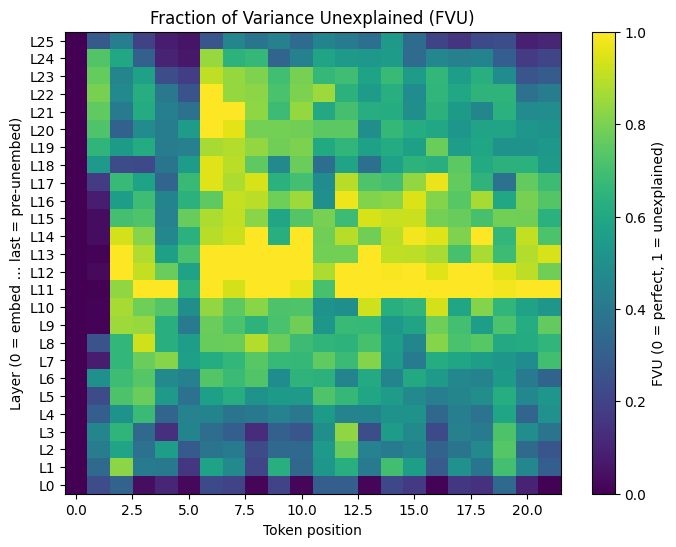

In [16]:
import torch, pandas as pd, matplotlib.pyplot as plt

# 1) run attribution pre-computation
logits, act_mat, err_vecs, tok_vecs = model.setup_attribution(
    prompt, sparse=False, zero_bos=True
)

n_layers, seq_len, _ = err_vecs.shape
fvu = torch.empty(n_layers, seq_len, device=err_vecs.device)

# 2) per-layer FVU =  ||error||² / variance(total MLP output)
for l in range(n_layers):
    decoded = model.transcoders[l].decode(act_mat[l])      # (seq, d_model)
    acts    = decoded + err_vecs[l]                        # original MLP out
    var     = (acts - acts.mean(dim=-2, keepdim=True)).pow(2).sum(dim=-1)
    se      = err_vecs[l].pow(2).sum(dim=-1)
    fvu[l]  = se / var.clamp(min=1e-8)

fvu_cpu = fvu.cpu()      # move to host for plotting

# ─── Heat-map ─────────────────────────────────────────────
plt.figure(figsize=(8,6))
plt.imshow(fvu_cpu, aspect="auto", vmin=0.0, vmax=1.0)

# layer ticks
plt.yticks(range(n_layers), labels=[f"L{l}" for l in range(n_layers)])
plt.gca().invert_yaxis()          # layer-0 at top

plt.xlabel("Token position")
plt.ylabel("Layer (0 = embed … last = pre-unembed)")
plt.title("Fraction of Variance Unexplained (FVU)")
plt.colorbar(label="FVU (0 = perfect, 1 = unexplained)")
plt.show()


In [17]:
max_n_logits = 2   # How many logits to attribute from, max. We attribute to min(max_n_logits, n_logits_to_reach_desired_log_prob); see below for the latter
desired_logit_prob = 0.95  # Attribution will attribute from the minimum number of logits needed to reach this probability mass (or max_n_logits, whichever is lower)
max_feature_nodes = 8192  # Only attribute from this number of feature nodes, max. Lower is faster, but you will lose more of the graph. None means no limit.
batch_size=256  # Batch size when attributing
offload='disk' if IN_COLAB else 'cpu' # Offload various parts of the model during attribution to save memory. Can be 'disk', 'cpu', or None (keep on GPU)
verbose = True  # Whether to display a tqdm progress bar and timing report

Then, just run attribution!

In [18]:
graph = attribute(
    prompt=prompt,
    model=model,
    max_n_logits=max_n_logits,
    desired_logit_prob=desired_logit_prob,
    batch_size=batch_size,
    max_feature_nodes=max_feature_nodes,
    offload=offload,
    verbose=verbose
)

Phase 0: Precomputing activations and vectors
Precomputation completed in 0.25s
Found 23260 active features
Phase 1: Running forward pass
Forward pass completed in 0.34s
Phase 2: Building input vectors
Selected 2 logits with cumulative probability 0.6172
Will include 8192 of 23260 feature nodes
Input vectors built in 1.41s
Phase 3: Computing logit attributions
Logit attributions completed in 0.20s
Phase 4: Computing feature attributions
Feature influence computation: 100%|██████| 8192/8192 [00:06<00:00, 1226.73it/s]
Feature attributions completed in 6.68s
Attribution completed in 12.94s


We now have a graph object! We can save it as a .pt file, but be warned that it's large (~167MB).

In [19]:
graph_dir = 'graphs'
graph_name = 'example_graph.pt'
graph_dir = Path(graph_dir)
graph_dir.mkdir(exist_ok=True)
graph_path = graph_dir / graph_name

graph.to_pt(graph_path)

Given this object, we can create the graph files that we need to visualize the graph. Give it a slug (name), and set the node / edge thresholds for pruning. Pruning removes unimportant nodes and edges from your graph; lower thresholds (i.e., more aggressive pruning) results in smaller graphs. These may be easier to interpret, but explain less of the model's behavior.

In [22]:
slug = "gemma_test"  # this is the name that you assign to the graph
graph_file_dir = './graph_files'  # where to write the graph files. no need to make this one; create_graph_files does that for you
node_threshold=0.8  # keep only the minimum # of nodes whose cumulative influence is >= 0.8
edge_threshold=0.98  # keep only the minimum # of edges whose cumulative influence is >= 0.98

create_graph_files(
    graph_or_path=graph_path,  # the graph to create files for
    slug=slug,
    output_path=graph_file_dir,
    node_threshold=node_threshold,
    edge_threshold=edge_threshold
)

Now, you can visualize the graph using the following commands! This will spin up a local server to act as the frontend.

**If you're running this notebook on a remote server, make sure that you set up port forwarding, so that the chosen port is accessible on your local machine too.**

You can select nodes by clicking on them. Ctrl/Cmd+Click on nodes to pin and unpin them to your subgraph. G+Click on nodes in the subgraph to group them together into a supernode; G+Click on the X next to a supernode to dissolve it. Click on the edit button to edit node descriptions, and click on supernode description to edit that.

In [26]:
from circuit_tracer.frontend.local_server import serve


port = 16667
server = serve(data_dir='./graph_files/', port=port)

if IN_COLAB:
    from google.colab import output as colab_output  # noqa
    colab_output.serve_kernel_port_as_iframe(port, path='/index.html', height='800px', cache_in_notebook=True)
else:
    from IPython.display import IFrame
    print(f"Use the IFrame below, or open your graph here: f'http://localhost:{port}/index.html'")
    display(IFrame(src=f'http://localhost:{port}/index.html', width='100%', height='800px'))


Use the IFrame below, or open your graph here: f'http://localhost:16667/index.html'


Once you're done, you can stop the server with the following command.

In [25]:
server.stop()

Congrats, you're done! Go to `intervention_demo.ipynb` to see how to perform interventions, or check out `gemma_demo.ipynb` and `llama_demo.ipynb` for examples of worked-out test examples. Read on for a bit more info aabout the Graph class and pruning.

## Graphs

Earlier, you created a graph object. Its adjacency matrix / edge weights are stored in `graph.adjacency_matrix` in a dense format; rows are target nodes and columns are source nodes. The first `len(graph.real_features)` entries of the matrix represent features; the `i`th entry corresponds to the `i`th feature in `graph.real_features`, given in `(layer, position, feature_idx)` format. The next `graph.cfg.n_layers * graph.n_pos` entries are error_nodes. The next `graph.n_pos` entries are token nodes. The final `len(graph.logit_tokens)` entries are logit nodes.

The value of the cell `graph.adjacency_matrix[target, source]` is the direct effect of the source node on the target node. That is, it tells you how much the target node's value would change if the source node were set to 0, while holding the attention patterns, layernorm denominators, and other feature activations constatnt. Thus, if the target node is a feature, this tells you how much the target feature would change; if the target node is a logit, this tells you how much the (de-meaned) value of the logit would change.

Note that `gemma-2-2b` is model (family) that uses logit softcapping. This means that a softcap function, `softcap(x) = t * tanh(x/t)` is used to constrain the logits to fall within (-t, t); `gemma-2-2b` uses `t=30`. For such models, we predict the change in logits *pre-softcap*, as the nonlinearity introduced by softcapping would cause our attribution to yield incorrect / approximate direct effect values.

### Pruning
Given a graph, you might want to prune it, as it will otherwise contain many low-impact nodes and edges that clutter the circuit diagram while adding little information. We enable you to prune nodes by absolute influence, i.e. the total impact that the nodes have on the logits, direct and indirect. The default threshold is 0.8: this means we will keep the minimum number of nodes required to capture 80% of all logit effects. Similarly, the edge_threshold, by default 0.98, means that we will keep the minimum number of edges required to capture 98% of all logit effects.

In [ ]:
from circuit_tracer.graph import prune_graph
prune_graph(graph, node_threshold=0.7, edge_threshold=0.95)